In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle

In [3]:
# 1. Download historical stock data
ticker = 'OR.PA'  # L'Oréal ticker on the Paris Stock Exchange
data = yf.download(ticker, start='2020-01-01', progress=False)
data.to_csv('loreal_historical_data.csv')  # Save data to a CSV file

In [5]:
# Reload data with date processing
data = pd.read_csv('loreal_historical_data.csv', parse_dates=['Date'], index_col='Date')


In [39]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA30,Log Return,Volatility,RSI,Target
Date,,,,,,,,,,,,,
2020-01-02,264.200012,266.700012,263.200012,264.200012,243.288681,351300,0.000000,0.0,0.0,0.000000,0.0,0.0,0
2020-01-03,260.899994,263.899994,260.600006,263.899994,243.012436,292884,0.000000,0.0,0.0,-0.001136,0.0,0.0,0
2020-01-06,261.299988,263.100006,258.799988,263.000000,242.183685,367820,0.000000,0.0,0.0,-0.003416,0.0,0.0,0
2020-01-07,264.000000,264.399994,258.899994,259.600006,239.052780,508141,0.000000,0.0,0.0,-0.013012,0.0,0.0,1
2020-01-08,260.100006,261.200012,257.799988,261.200012,240.526154,431996,262.380005,0.0,0.0,0.006144,0.0,0.0,1


In [43]:
# Check for missing values
print("\nMissing values:")
data.isnull().sum()


Missing values:


Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
MA5           0
MA10          0
MA30          0
Log Return    0
Volatility    0
RSI           0
Target        0
dtype: int64

In [45]:
# 2. Compute technical indicators
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()
data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['Volatility'] = data['Log Return'].rolling(window=30).std() * np.sqrt(30)

In [11]:
# RSI calculation
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

In [13]:
# Fill missing values
data = data.fillna(0)

In [15]:
# 3. Prepare the dataset
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)  # Create target variable


In [17]:
# Select features
features = ['MA5', 'MA10', 'MA30', 'Volatility', 'RSI']
X = data[features]
y = data['Target']

In [19]:
# Split the dataset
train_size = 0.6
validation_size = 0.2

In [21]:
train_end = int(len(data) * train_size)
validation_end = int(len(data) * (train_size + validation_size))

X_train = X[:train_end]
y_train = y[:train_end]
X_validation = X[train_end:validation_end]
y_validation = y[train_end:validation_end]
X_test = X[validation_end:]
y_test = y[validation_end:]

In [23]:
# Standardize data only for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [25]:
# 4. Train and evaluate models
def evaluate_model(model, X_train, y_train, X_validation, y_validation, X_test, y_test, scale=False):
    # Apply scaling if needed
    if scale:
        X_train, X_validation, X_test = X_train_scaled, X_validation_scaled, X_test_scaled
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_validation = model.predict(X_validation)
    y_pred_test = model.predict(X_test)
    
    # Evaluation
    validation_accuracy = accuracy_score(y_validation, y_pred_validation)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    validation_roc_auc = roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1]) if hasattr(model, "predict_proba") else None
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else None
    
    # Summary
    print(f"Validation Accuracy: {validation_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")
    if validation_roc_auc and test_roc_auc:
        print(f"Validation ROC-AUC: {validation_roc_auc:.2f}, Test ROC-AUC: {test_roc_auc:.2f}")
    
    print("Classification Report (Validation):")
    print(classification_report(y_validation, y_pred_validation))
    print("Confusion Matrix (Validation):")
    print(confusion_matrix(y_validation, y_pred_validation))
    
    # Save the trained model with pickle
    model_name = model.__class__.__name__
    with open(f'{model_name}_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model {model_name} saved successfully!")
    return validation_accuracy, test_accuracy, validation_roc_auc, test_roc_auc

In [27]:
# Logistic Regression
print("\nLogistic Regression:")
logistic_model = LogisticRegression()
evaluate_model(logistic_model, X_train, y_train, X_validation, y_validation, X_test, y_test, scale=True)



Logistic Regression:
Validation Accuracy: 0.50, Test Accuracy: 0.48
Validation ROC-AUC: 0.41, Test ROC-AUC: 0.51
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.50      1.00      0.67       126

    accuracy                           0.50       252
   macro avg       0.25      0.50      0.33       252
weighted avg       0.25      0.50      0.33       252

Confusion Matrix (Validation):
[[  0 126]
 [  0 126]]
Model LogisticRegression saved successfully!


C:\Users\Admin-IT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin-IT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin-IT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5, 0.47619047619047616, 0.41156462585034015, 0.5083964646464647)

In [29]:
# Random Forest
print("\nRandom Forest:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_validation, y_validation, X_test, y_test)



Random Forest:
Validation Accuracy: 0.54, Test Accuracy: 0.54
Validation ROC-AUC: 0.54, Test ROC-AUC: 0.50
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       126
           1       0.54      0.58      0.56       126

    accuracy                           0.54       252
   macro avg       0.54      0.54      0.54       252
weighted avg       0.54      0.54      0.54       252

Confusion Matrix (Validation):
[[64 62]
 [53 73]]
Model RandomForestClassifier saved successfully!


(0.5436507936507936,
 0.5357142857142857,
 0.5370055429579239,
 0.49687499999999996)

In [31]:
# XGBoost
print("\nXGBoost:")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)
evaluate_model(xgb_model, X_train, y_train, X_validation, y_validation, X_test, y_test)



XGBoost:
Validation Accuracy: 0.54, Test Accuracy: 0.52
Validation ROC-AUC: 0.55, Test ROC-AUC: 0.52
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.53      0.56      0.54       126
           1       0.54      0.52      0.53       126

    accuracy                           0.54       252
   macro avg       0.54      0.54      0.54       252
weighted avg       0.54      0.54      0.54       252

Confusion Matrix (Validation):
[[70 56]
 [61 65]]
Model XGBClassifier saved successfully!


C:\Users\Admin-IT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(0.5357142857142857,
 0.5198412698412699,
 0.5471466364323507,
 0.5162247474747474)

C:\Users\Admin-IT\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin-IT\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


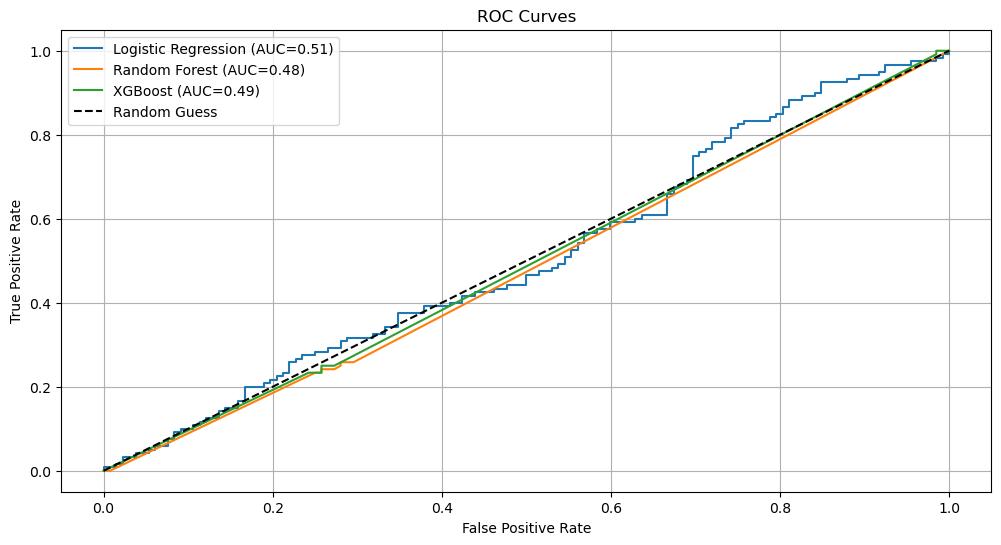

In [33]:
# 5. Compare models using ROC curves
def plot_roc_curves(models, names, X_validation, y_validation, X_test, y_test):
    plt.figure(figsize=(12, 6))
    for model, name in zip(models, names):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]):.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

# Plot ROC curves for all models
plot_roc_curves(
    [logistic_model, rf_model, xgb_model],
    ["Logistic Regression", "Random Forest", "XGBoost"],
    X_validation_scaled, y_validation, X_test_scaled, y_test
)


In [35]:
# 6. Load a model and use it for prediction
# Load the logistic regression model for example
with open('LogisticRegression_model.pkl', 'rb') as f:
    loaded_logistic_model = pickle.load(f)




In [37]:
# Make predictions with the loaded model
y_pred_loaded_model = loaded_logistic_model.predict(X_test_scaled)
print("\nPredictions with Loaded Model:")
print(y_pred_loaded_model[:10])  # Print the first 10 predictions


Predictions with Loaded Model:
[1 1 1 1 1 1 1 1 1 1]
